# Proyek Klasifikasi Gambar: [Sandwhich, Fries, and, Donut]
- **Nama:** Achmad Fariz Rizky Yanuar
- **Email:** 03achmadfariz@gmail.com
- **ID Dicoding:** fcrizz

# Import library

In [6]:
!pip install tensorflowjs

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


# Data Prep

## Data Loading

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install -q kaggle


In [3]:
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0


In [4]:
!unzip food-image-classification-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Food Classification dataset/idli/277.jpg  
  inflating: dataset/Food Classification dataset/idli/278.jpg  
  inflating: dataset/Food Classification dataset/idli/280.jpg  
  inflating: dataset/Food Classification dataset/idli/282.jpg  
  inflating: dataset/Food Classification dataset/idli/283.jpg  
  inflating: dataset/Food Classification dataset/idli/284.jpg  
  inflating: dataset/Food Classification dataset/idli/285.jpg  
  inflating: dataset/Food Classification dataset/idli/286.jpg  
  inflating: dataset/Food Classification dataset/idli/287.jpg  
  inflating: dataset/Food Classification dataset/idli/288.jpg  
  inflating: dataset/Food Classification dataset/idli/290.jpg  
  inflating: dataset/Food Classification dataset/idli/292.jpg  
  inflating: dataset/Food Classification dataset/idli/293.jpg  
  inflating: dataset/Food Classification dataset/idli/295.jpg  
  inflating: dataset/Food Classification dataset/idli

In [7]:
random.seed(42)
img_size = (150, 150)
batch_size = 32

In [31]:
selected_classes = ["Sandwich", "Fries", "Donut"]
source_base = "/content/dataset/Food Classification dataset"
merged_dataset_path = "/content/merged_food_dataset"
os.makedirs(merged_dataset_path, exist_ok=True)

for class_name in selected_classes:
    class_path = os.path.join(source_base, class_name)
    merged_class_path = os.path.join(merged_dataset_path, class_name)
    os.makedirs(merged_class_path, exist_ok=True)

    for img_file in os.listdir(class_path):
        src = os.path.join(class_path, img_file)
        dst = os.path.join(merged_class_path, img_file)
        shutil.copy(src, dst)

Hanya memilih class Sandwitch, Fries, dan Donut.

# Data Preprocessing

## Split dataset

In [8]:
# Split Dataset
output_base = "/content/split_dataset"
train_dir = os.path.join(output_base, "train")
val_dir = os.path.join(output_base, "val")
test_dir = os.path.join(output_base, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

for class_name in tqdm(os.listdir(merged_dataset_path), desc="Splitting"):
    class_path = os.path.join(merged_dataset_path, class_name)
    images = os.listdir(class_path)

    train_imgs, testval_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

    for subset, subset_imgs in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        subset_class_dir = os.path.join(subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)
        for img in subset_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(subset_class_dir, img))

Splitting: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Bagian kode di atas melakukan pembagian dataset yang telah digabung ke dalam tiga subset: **train (70%)**, **validation (15%)**, dan **test (15%)**. Untuk setiap kelas, gambar-gambar dipisahkan secara acak menggunakan `train_test_split` dari scikit-learn. Setelah itu, gambar-gambar dari masing-masing subset disalin ke direktori yang sesuai (`train/`, `val/`, dan `test/`) dengan struktur folder per kelas agar dapat digunakan oleh generator gambar seperti `ImageDataGenerator` di Keras.

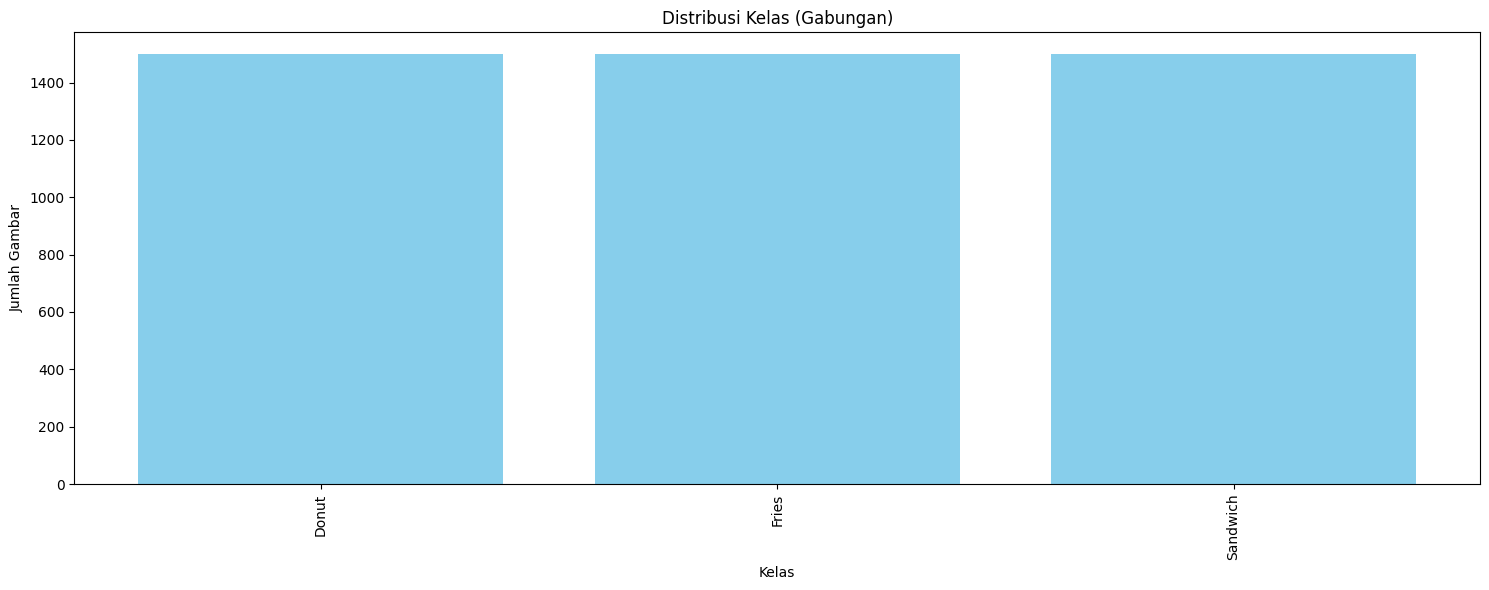


📊 Jumlah gambar per kelas di Distribusi Kelas (Gabungan):
Donut: 1500
Fries: 1500
Sandwich: 1500
----------------------------------------


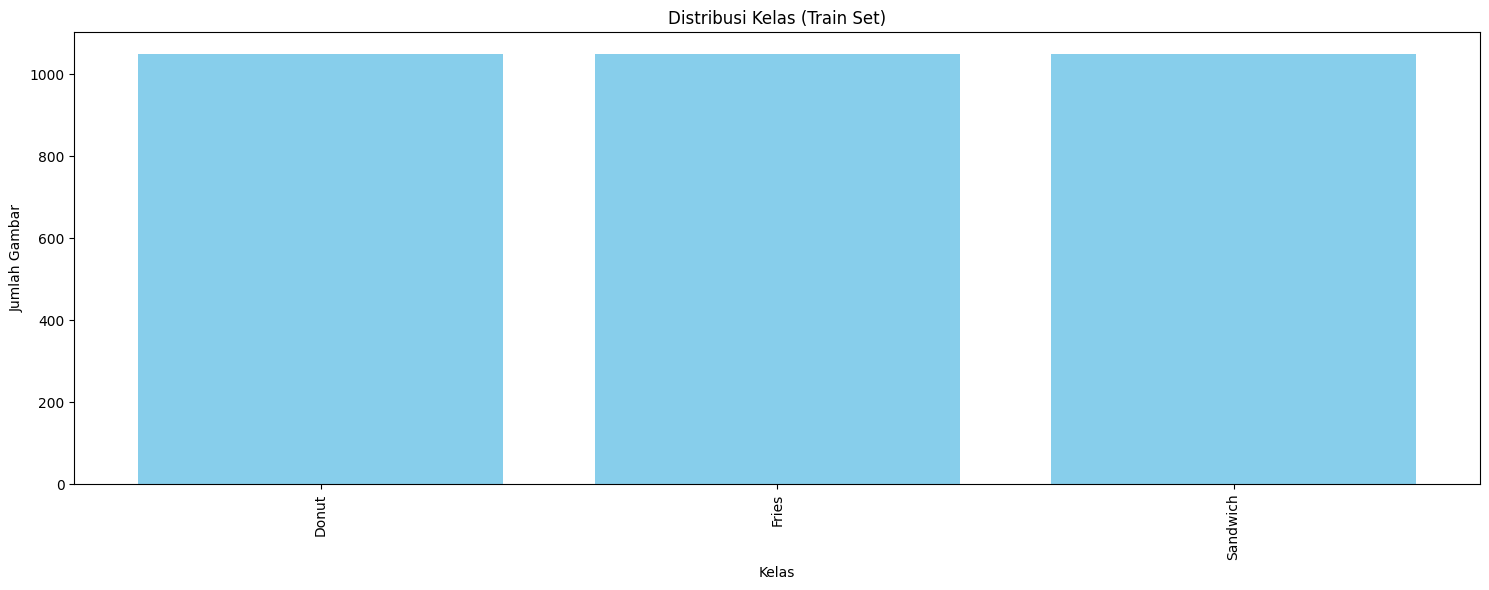


📊 Jumlah gambar per kelas di Distribusi Kelas (Train Set):
Donut: 1050
Fries: 1050
Sandwich: 1050
----------------------------------------


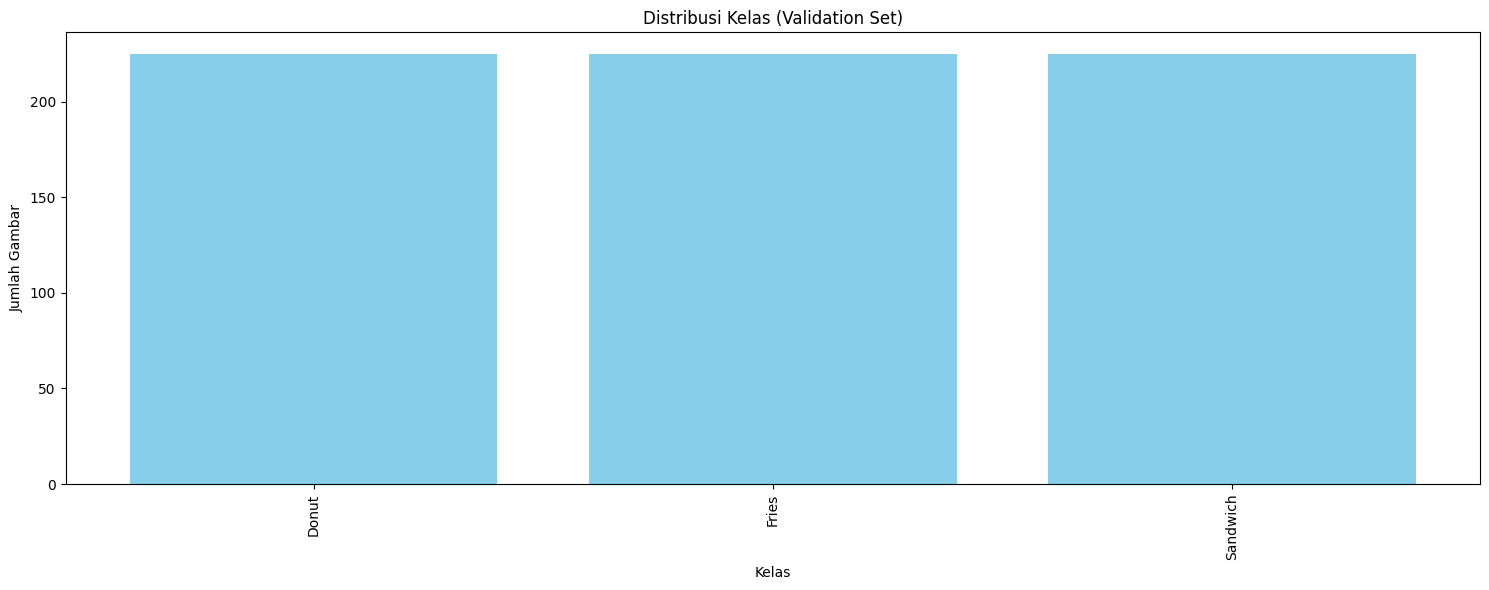


📊 Jumlah gambar per kelas di Distribusi Kelas (Validation Set):
Donut: 225
Fries: 225
Sandwich: 225
----------------------------------------


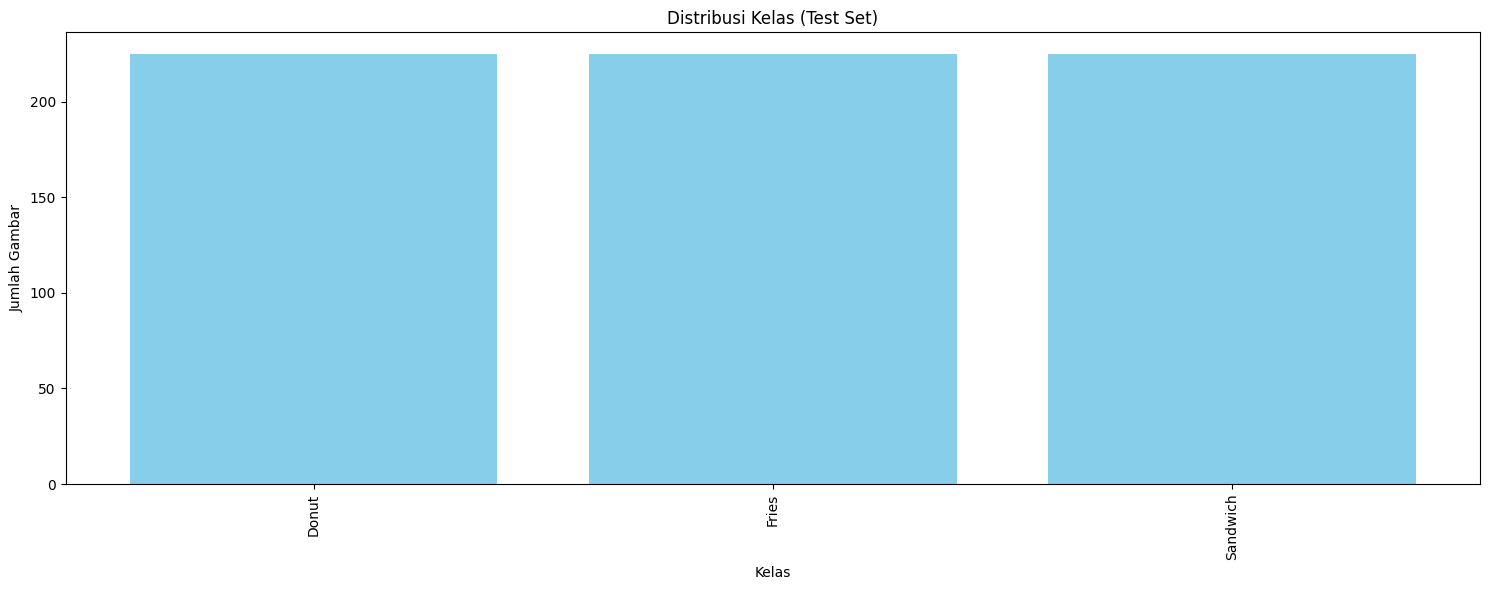


📊 Jumlah gambar per kelas di Distribusi Kelas (Test Set):
Donut: 225
Fries: 225
Sandwich: 225
----------------------------------------


In [9]:
# Melihat distribusi kelas
def plot_and_print_distribution(folder_path, title="Distribusi Kelas"):
    class_counts = {cls: len(os.listdir(os.path.join(folder_path, cls)))
                    for cls in os.listdir(folder_path)
                    if os.path.isdir(os.path.join(folder_path, cls))}

    class_counts = dict(sorted(class_counts.items()))

    plt.figure(figsize=(15, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.tight_layout()
    plt.show()

    print(f"\n📊 Jumlah gambar per kelas di {title}:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    print("-" * 40)

plot_and_print_distribution(merged_dataset_path, "Distribusi Kelas (Gabungan)")
plot_and_print_distribution(train_dir, "Distribusi Kelas (Train Set)")
plot_and_print_distribution(val_dir, "Distribusi Kelas (Validation Set)")
plot_and_print_distribution(test_dir, "Distribusi Kelas (Test Set)")

In [10]:
# Cek resolusi dataset
from PIL import Image
import os

def print_images_resolution(directory):
    total_images = 0

    for subdir in sorted(os.listdir(directory)):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        total_images += num_images
        print(f"{subdir}: {num_images} gambar")

        unique_sizes = set()
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Gagal buka gambar: {img_file} ({e})")

        for size in unique_sizes:
            print(f"  - Resolusi unik: {size}")
        print("---------------")

    print(f"\n Total keseluruhan gambar: {total_images}")

print_images_resolution("/content/merged_food_dataset")

Donut: 1500 gambar
  - Resolusi unik: (920, 920)
  - Resolusi unik: (176, 286)
  - Resolusi unik: (736, 736)
  - Resolusi unik: (243, 208)
  - Resolusi unik: (225, 224)
  - Resolusi unik: (188, 269)
  - Resolusi unik: (190, 266)
  - Resolusi unik: (1200, 1200)
  - Resolusi unik: (220, 136)
  - Resolusi unik: (200, 252)
  - Resolusi unik: (202, 249)
  - Resolusi unik: (201, 251)
  - Resolusi unik: (1365, 2048)
  - Resolusi unik: (203, 248)
  - Resolusi unik: (576, 576)
  - Resolusi unik: (223, 226)
  - Resolusi unik: (369, 280)
  - Resolusi unik: (186, 271)
  - Resolusi unik: (187, 270)
  - Resolusi unik: (189, 267)
  - Resolusi unik: (168, 299)
  - Resolusi unik: (276, 183)
  - Resolusi unik: (860, 664)
  - Resolusi unik: (1023, 670)
  - Resolusi unik: (297, 169)
  - Resolusi unik: (254, 198)
  - Resolusi unik: (1300, 1390)
  - Resolusi unik: (259, 194)
  - Resolusi unik: (227, 223)
  - Resolusi unik: (185, 272)
  - Resolusi unik: (331, 152)
  - Resolusi unik: (5120, 2880)
  - Resolusi

# Image Augmentation

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                                    batch_size=batch_size, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=img_size,
                                                     batch_size=batch_size, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=img_size,
                                                      batch_size=batch_size, class_mode='categorical',
                                                      shuffle=False)

Found 3150 images belonging to 3 classes.
Found 675 images belonging to 3 classes.
Found 675 images belonging to 3 classes.


train_datagen memiliki augmentasi (rotasi, zoom, flip horizontal) agar model lebih general terhadap variasi gambar.

val_test_datagen hanya melakukan normalisasi (rescale), karena data validasi dan test tidak boleh dimodifikasi secara agresif.

Hasil: dataset terbagi menjadi 3150 gambar untuk training, 675 untuk validation, dan 675 untuk testing, dari total 3 kelas.

# Modeling

In [12]:
# Menggunkan base model VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,100,419 (57.60 MB)

 Trainable params: 385,731 (1.47 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model yang digunakan dalam proyek ini adalah VGG16 sebagai base model dengan bobot pra-pelatihan dari ImageNet dan tanpa bagian klasifikasi atas (`include_top=False`). Layer dari VGG16 dibekukan agar tidak dilatih ulang. Di atasnya, ditambahkan beberapa layer konvolusional, pooling, dan dense untuk menyesuaikan dengan jumlah kelas dataset yang digunakan. Model ini dikompilasi menggunakan optimizer Adam, fungsi loss `categorical_crossentropy`, dan metrik akurasi untuk klasifikasi multikelas. Arsitektur ini memanfaatkan kekuatan transfer learning untuk menghasilkan model yang lebih cepat konvergen dan akurat pada dataset dengan ukuran terbatas.

In [18]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_generator, validation_data=val_generator, epochs=20,
                    callbacks=[early_stop])

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.9447 - loss: 0.2776 - val_accuracy: 0.8711 - val_loss: 0.5064
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9445 - loss: 0.2857 - val_accuracy: 0.9052 - val_loss: 0.4150
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.9490 - loss: 0.2720 - val_accuracy: 0.8963 - val_loss: 0.4171
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9492 - loss: 0.2608 - val_accuracy: 0.9126 - val_loss: 0.4078
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9512 - loss: 0.2631 - val_accuracy: 0.8844 - val_loss: 0.4294
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.9525 - loss: 0.2560 - val_accuracy: 0.9111 - val_loss: 0.3982
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9511 - loss: 0.2485 - val_accuracy: 0.9022 - val_loss: 0.4119
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9578 - loss: 0.2514 - val_accu

#  Evaluasi dan Visualisasi

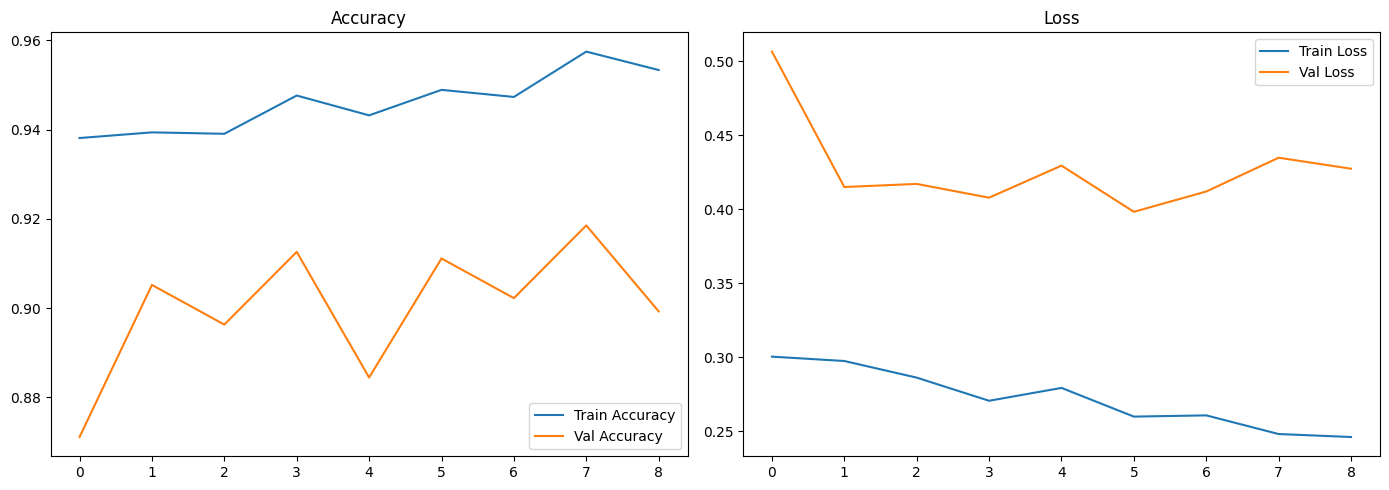

In [19]:
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

plot_history(history)

Berdasarkan grafik akurasi dan loss di atas, model menunjukkan kinerja yang cukup stabil selama pelatihan. Akurasi training cenderung meningkat dan stabil di atas 94%, sedangkan akurasi validasi menunjukkan fluktuasi ringan di sekitar 90%, yang mengindikasikan model mampu melakukan generalisasi dengan cukup baik meskipun masih ada potensi peningkatan. Pada grafik loss, training loss terus menurun, menunjukkan model belajar dengan baik, sementara validasi loss sedikit naik-turun, yang bisa menandakan adanya sedikit overfitting namun masih dalam batas wajar. Secara keseluruhan, performa model tergolong baik dan konsisten.

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9102 - loss: 0.4347 

 Test Accuracy: 88.15%
 Test Loss: 0.4972
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step

 Classification Report:
              precision    recall  f1-score   support

       Donut       0.87      0.93      0.90       225
       Fries       0.86      0.92      0.89       225
    Sandwich       0.92      0.80      0.86       225

    accuracy                           0.88       675
   macro avg       0.88      0.88      0.88       675
weighted avg       0.88      0.88      0.88       675



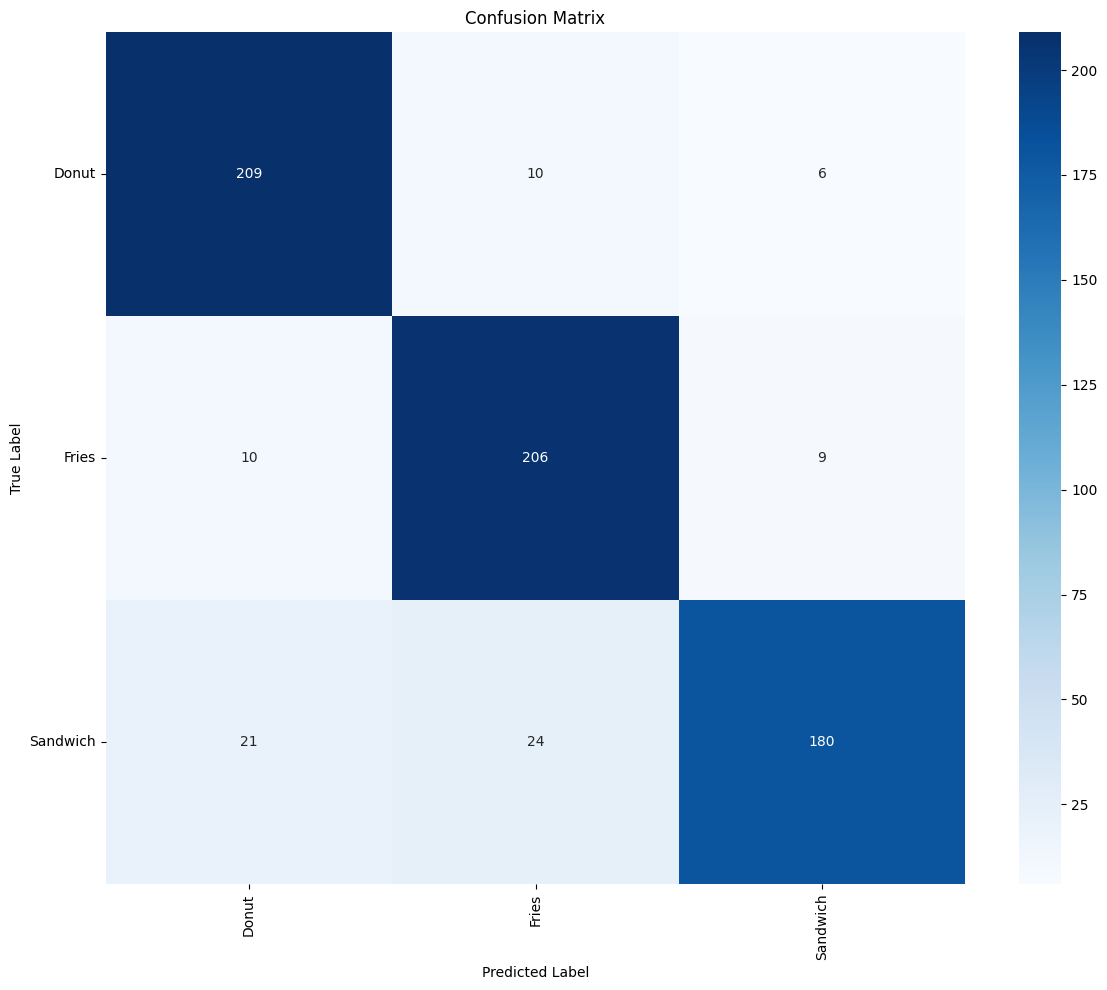

In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# Classification Report & Confusion Matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model klasifikasi makanan berhasil mencapai akurasi **88.15%** pada data uji, dengan nilai **loss sebesar 0.4972**. Berdasarkan laporan klasifikasi, kelas *Donut* dan *Fries* memiliki f1-score tinggi yaitu 0.90 dan 0.89, sementara kelas *Sandwich* sedikit lebih rendah di 0.86 karena recall-nya 0.80. Hal ini menunjukkan bahwa model secara umum cukup andal dalam mengenali ketiga kelas, meskipun masih terdapat potensi peningkatan pada kelas *Sandwich*. Distribusi presisi dan recall yang seimbang juga mengindikasikan performa yang stabil tanpa bias yang signifikan antar kelas.


# Konversi Model

In [26]:
tf.saved_model.save(model, '/content/model/saved_model')

In [29]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/model/saved_model/ \
    /content/tfjs_model

2025-04-20 15:03:59.236235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745161439.256479   10743 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745161439.262962   10743 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-20 15:04:04.713230: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745161444.713432   10743 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [28]:
# tflite
tflite_model = tf.lite.TFLiteConverter.from_saved_model("/content/model/saved_model").convert()
os.makedirs("/content/model/tflite", exist_ok=True)
with open("/content/model/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

class_labels = list(train_generator.class_indices.keys())
with open("/content/model/tflite/label.txt", "w") as f:
    for label in class_labels:
        f.write(label + "\n")

# Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


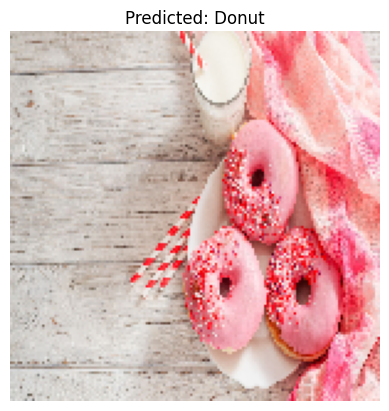

In [32]:
sample_path = test_generator.filepaths[0]
img = image.load_img(sample_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Pastikan label didefinisikan
labels = list(train_generator.class_indices.keys())

pred = model.predict(img_array)
pred_class = labels[np.argmax(pred)]

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_class}")
plt.show()

In [30]:
! pip freeze > requirements.txt
! pip list --format=freeze > requirements.txt